In [1]:
%matplotlib inline
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import re
import numpy as np
import pandas as pd
from graphdot import Graph
from graphdot.kernel.marginalized import MarginalizedGraphKernel
from graphdot.kernel.basekernel import TensorProduct
from graphdot.kernel.basekernel import SquareExponential
from graphdot.kernel.basekernel import KroneckerDelta
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
import networkx as nx
from rdkit.Chem import MolFromSmiles
def smile2graph(smile):
    mol = MolFromSmiles(smile)

    if mol is not None:
        g = nx.Graph()

        for i, atom in enumerate(mol.GetAtoms()):
            g.add_node(i)
            #g.nodes[i]['symbol'] = atom.GetAtomicNum()
            g.nodes[i]['charge'] = atom.GetFormalCharge()
            g.nodes[i]['hcount'] = atom.GetTotalNumHs()
            g.nodes[i]['hybridization'] = atom.GetHybridization()
            g.nodes[i]['aromatic'] = atom.GetIsAromatic()
            g.nodes[i]['chiral'] = atom.GetChiralTag()

        for bond in mol.GetBonds():
            ij = (bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
            g.add_edge(*ij)
            g.edges[ij]['order'] = bond.GetBondType()
            g.edges[ij]['aromatic'] = bond.GetIsAromatic()
            g.edges[ij]['conjugated'] = bond.GetIsConjugated()
            g.edges[ij]['stereo'] = bond.GetStereo()
            g.edges[ij]['inring'] = bond.IsInRing()

        return Graph.from_networkx(g)
    else:
        return None
    
# defining kernel
class NormalizedKernel(MarginalizedGraphKernel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def __normalize(self, X, Y, R):
        if type(R) is tuple:
            d = np.diag(R[0])**-0.5
            K = np.diag(d).dot(R[0]).dot(np.diag(d))
            return (K, R[1])
        else:
            if Y is None:
                # square matrix
                d = np.diag(R)**-0.5
                K = np.diag(d).dot(R).dot(np.diag(d))
            else:
                # rectangular matrix, must have X and Y
                diag_X = super().diag(X)**-0.5
                diag_Y = super().diag(Y)**-0.5
                K = np.diag(diag_X).dot(R).dot(np.diag(diag_Y))
            return K
    def __call__(self, X, Y=None, *args, **kwargs):
        R = super().__call__(X, Y, *args, **kwargs)
        return self.__normalize(X, Y, R)

#initializing kernel
knode = TensorProduct(aromatic=KroneckerDelta(0.8),
                      charge=SquareExponential(1.0),
                      hcount=SquareExponential(1.0))

kedge = TensorProduct(order=KroneckerDelta(0.5))

normal_kernel = NormalizedKernel(knode, kedge, q=0.05)
kernel = MarginalizedGraphKernel(knode, kedge, q=0.05)

RDKit WARNING: [04:11:53] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
class OutputHandler():
    def __init__(self, filename, relative_dir='../result'):
        self.df = pd.read_csv(os.path.join(relative_dir, filename), sep=" ")
        self._parse_argument(filename)
    def _parse_argument(self, filename):
        self.target, self.learning_mode, self.add_mode, self.add_size, _ = re.split('-', filename)

In [4]:
pathDir = os.listdir('../result')

In [5]:
sorted(pathDir)

['dc-random-cluster-10-comp.out',
 'dc-random-cluster-10-comp_all.out',
 'dc-supervised-cluster-10-comp.out',
 'dc-supervised-nlargest-10-comp.out',
 'dc-supervised-random-10-comp.out',
 'dc-unsupervised-cluster-10-666.out',
 'dc-unsupervised-cluster-10-comp.out',
 'dc-unsupervised-cluster-10-comp_all.out',
 'dc-unsupervised-cluster-10-debug.out',
 'dc-unsupervised-cluster-15-debug.out',
 'dc-unsupervised-cluster-15-nystrom.out',
 'dc-unsupervised-nlargest-10-comp.out',
 'dc-unsupervised-nlargest-10-comp_all.out',
 'dc-unsupervised-random-10-comp.out',
 'dc-unsupervised-threshold-10-debug.out',
 'dc-unsupervised-threshold-10-std_log.out',
 'dc-unsupervised-threshold-10-threshold_test_11.out',
 'dc-unsupervised-threshold-10-threshold_test_9.out',
 'dc-unsupervised-threshold-200-10-threshold_test.out',
 'result-debug',
 'result-density-100to1000',
 'result-density-npt-100to1000',
 'result-density-npt-test',
 'result-density-test',
 'result-npt-density-random',
 'result-npt-density-superv

# comparison between different add mode for unsupervised active learning on dc

In [6]:
def plot_oh(oh, get_str, target='r2'): # oh==OutputHandler
    if oh.learning_mode == 'supervised':
        color = 'cornflowerblue'
    elif oh.learning_mode == 'random':
        color = 'grey'
    elif oh.learning_mode == 'unsupervised':
        color = 'orange'
    if oh.add_mode == 'cluster':
        linestyle = '-'
    elif oh.add_mode == 'nlargest':
        linestyle = '--'
    elif oh.add_mode == 'random':
        linestyle = '-.'
    #plt.scatter(oh.df['size'], oh.df[target], s=5, c=color)
    plt.plot(oh.df['#size'], oh.df[target], c=color, linestyle=linestyle, label=get_str(oh))
    
def get_str(oh):
    return ('%s-%s' % (oh.learning_mode, oh.add_mode) )

In [31]:
out_list = ['dc-random-cluster-10-comp.out',
 #'dc-supervised-cluster-10-comp.out',
 'dc-supervised-nlargest-10-comp.out',
 #'dc-supervised-random-10-comp.out',
 'dc-unsupervised-cluster-10-comp.out',
 'dc-unsupervised-nlargest-10-comp.out',
 'dc-unsupervised-random-10-comp.out']

oh_list = [OutputHandler(i) for i in out_list]
df_threshold_9 = pd.read_csv('../result/dc-unsupervised-threshold-10-threshold_test_9.out', sep=" ")
df_threshold_11 = pd.read_csv('../result/dc-unsupervised-threshold-10-threshold_test_11.out', sep=" ")
df_threshold_9.drop( df_threshold_9 [df_threshold_9['r2']<0.75].index, inplace=True )
df_threshold_11.drop( df_threshold_11 [df_threshold_11['r2']<0.75].index, inplace=True )

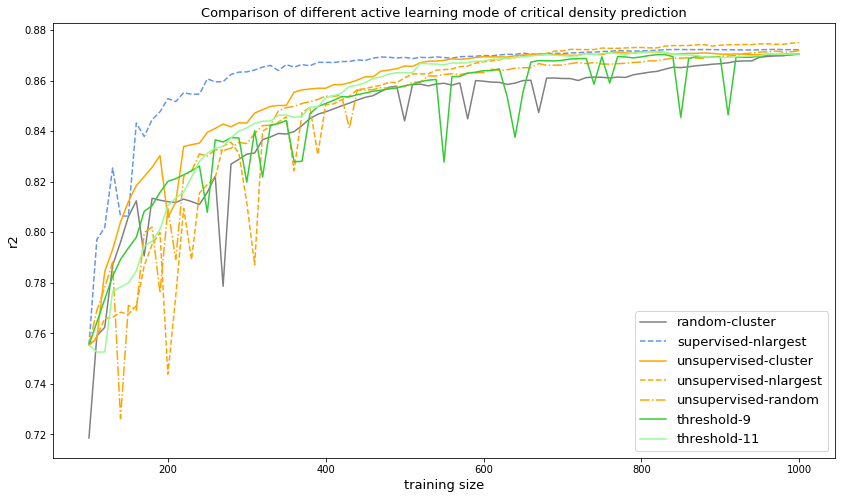

In [32]:
fig = plt.figure(figsize=(14,8))
for oh in oh_list:
    plot_oh(oh, get_str, 'r2')
fontsize = 13
#plt.plot(df_old_cluster['size'], df_old_cluster['r2'], c='r', label='old-unsupervised-cluster')
plt.plot(df_threshold_9['size'], df_threshold_9['r2'], c='limegreen', label='threshold-9')
plt.plot(df_threshold_11['size'], df_threshold_11['r2'], c='palegreen', label='threshold-11')

plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('r2', fontsize=fontsize)
plt.title('Comparison of different active learning mode of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

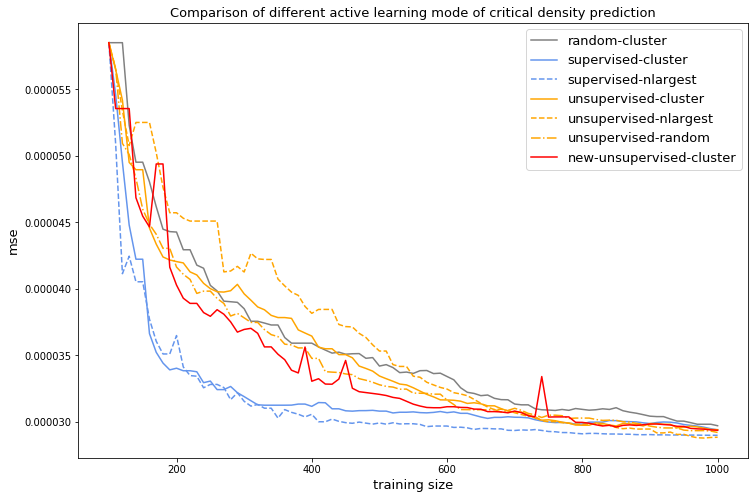

In [11]:
fig = plt.figure(figsize=(12,8))
for oh in oh_list:
    plot_oh(oh,  get_str, 'mse')
fontsize = 13
plt.xlabel('training size', fontsize=fontsize)
plt.plot(df_new_cluster['size'], df_new_cluster['mse'], c='r', label='new-unsupervised-cluster')
plt.ylabel('mse', fontsize=fontsize)
plt.title('Comparison of different active learning mode of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

# comparison for different search size for unsupervised

In [34]:
out_list2 =  [ 'dc-unsupervised-random-200-5.out',
 'dc-unsupervised-random-400-5.out',
 'dc-unsupervised-random-50-5.out',
 'dc-unsupervised-random-0-5.out',
 'dc-unsupervised-cluster-0-5.out',
 'dc-unsupervised-cluster-200-5.out',
 'dc-unsupervised-cluster-400-5.out',
 'dc-unsupervised-cluster-50-5.out'
            ]

In [35]:
oh_list2 = [OutputHandler(i) for i in out_list2]

In [36]:
def plot_oh2(oh, get_str, target='r2'): # oh==OutputHandler
    if oh.add_mode == 'random':
        linestyle = '-'
    elif oh.add_mode == 'cluster':
        linestyle = '--'

    if oh.search_size == '0':
        color = 0
    else:
        color = (1-int(oh.search_size)**0.5 / 25)
    cmap=plt.get_cmap('autumn')
    plt.plot(oh.df['size'], oh.df[target], c=cmap(color), label=get_str(oh), linestyle=linestyle)
    
def get_str(oh):
    return ('%s-%s' % (oh.learning_mode, oh.add_mode) )

def get_str2(oh):
    return ('%s-search:%s-add:%s' % (oh.add_mode, oh.search_size, oh.add_size))

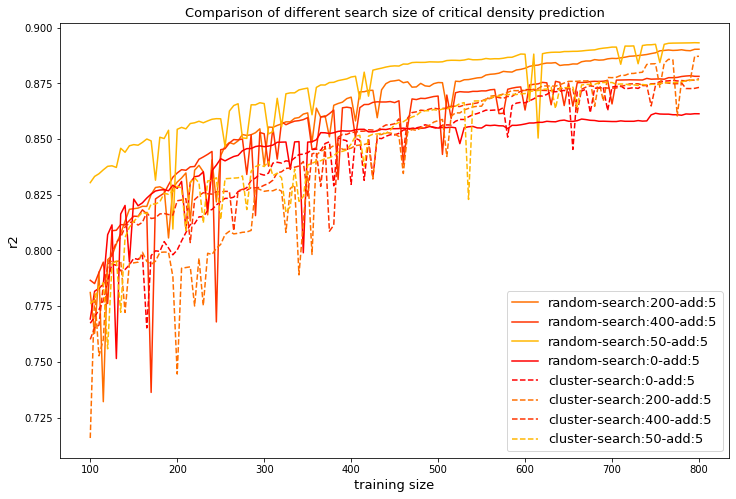

In [37]:
fig = plt.figure(figsize=(12,8))
for oh in oh_list2:
    plot_oh2(oh, get_str2, 'r2')
fontsize = 13
plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('r2', fontsize=fontsize)
plt.title('Comparison of different search size of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

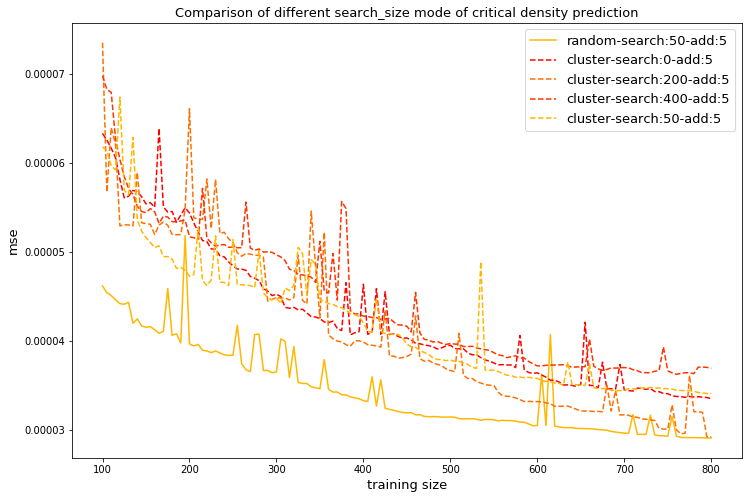

In [13]:
fig = plt.figure(figsize=(12,8))
for oh in oh_list2:
    plot_oh2(oh, get_str2, 'mse')
fontsize = 13
plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('mse', fontsize=fontsize)
plt.title('Comparison of different search_size mode of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

# comparison for different add size for unsupervised

In [17]:
out_list3 =  [ 
 'dc-unsupervised-cluster-200-10.out',
 'dc-unsupervised-cluster-200-40.out',
 'dc-unsupervised-cluster-200-5.out',
 'dc-unsupervised-random-200-10.out',
 'dc-unsupervised-random-200-2.out',
 'dc-unsupervised-random-200-40.out',
 'dc-unsupervised-random-200-5.out',
            ]
oh_list3 = [OutputHandler(i) for i in out_list3]

In [24]:
def plot_oh3(oh, get_str, target='r2'): # oh==OutputHandler
    if oh.add_mode == 'random':
        linestyle = '-'
    elif oh.add_mode == 'cluster':
        linestyle = '--'

    if oh.search_size == '0':
        color = 1
    else:
        color = int(oh.add_size)**0.5 / 5
    color = 1-color
    cmap=plt.get_cmap('autumn')
    plt.plot(oh.df['size'], oh.df[target], c=cmap(color), label=get_str(oh), linestyle=linestyle)
    
def get_str(oh):
    return ('%s-%s' % (oh.learning_mode, oh.add_mode) )

def get_str3(oh):
    return ('%s-search:%s-add:%s' % (oh.add_mode, oh.search_size, oh.add_size))

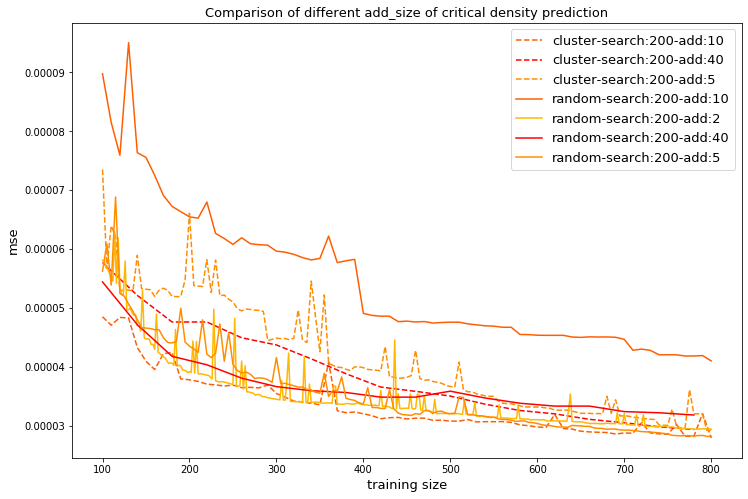

In [25]:
fig = plt.figure(figsize=(12,8))
for oh in oh_list3:
    plot_oh3(oh, get_str3, 'mse')
fontsize = 13
plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('mse', fontsize=fontsize)
plt.title('Comparison of different add_size of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

# std change 

In [2]:
pathDir2 = os.listdir('../log/std_log')

pathDir2

['99-970.csv',
 '859-210.csv',
 '429-640.csv',
 '669-400.csv',
 '189-880.csv',
 '739-330.csv',
 '579-490.csv',
 '489-580.csv',
 '809-260.csv',
 '719-350.csv',
 '249-820.csv',
 '969-100.csv',
 '539-530.csv',
 '139-930.csv',
 '709-360.csv',
 '749-320.csv',
 '179-890.csv',
 '449-620.csv',
 '759-310.csv',
 '919-150.csv',
 '929-140.csv',
 '439-630.csv',
 '599-470.csv',
 '549-520.csv',
 '839-230.csv',
 '209-860.csv',
 '319-750.csv',
 '789-280.csv',
 '629-440.csv',
 '459-610.csv',
 '169-900.csv',
 '829-240.csv',
 '879-190.csv',
 '409-660.csv',
 '279-790.csv',
 '569-500.csv',
 '649-420.csv',
 '769-300.csv',
 '149-920.csv',
 '299-770.csv',
 '729-340.csv',
 '479-590.csv',
 '129-940.csv',
 '799-270.csv',
 '949-120.csv',
 '159-910.csv',
 '679-390.csv',
 '559-510.csv',
 '119-950.csv',
 '349-720.csv',
 '219-850.csv',
 '199-870.csv',
 '289-780.csv',
 '419-650.csv',
 '959-110.csv',
 '269-800.csv',
 '899-170.csv',
 '689-380.csv',
 '869-200.csv',
 '229-840.csv',
 '79-990.csv',
 '519-550.csv',
 '89-980.c

In [3]:
df_list = []
for file in pathDir2:
    df = pd.read_csv('../log/std_log/'+file)
    df['size'] = re.split('-|\.', file)[1]
    df_list.append(df)

df = pd.concat(df_list)

grouped = df.groupby('size')

describe = grouped['std'].describe()
describe

,count,mean,std,min,25%,50%,75%,max
size,,,,,,,,
100,969.0,12.623205,3.750236,4.610760,10.165022,12.046301,14.341410,35.216255
1000,69.0,14.890154,3.966839,6.917012,11.861129,14.587591,18.373739,21.481798
110,959.0,12.623815,3.757620,4.610760,10.164502,12.050678,14.349733,35.216255
120,949.0,12.589490,3.690969,4.610760,10.163981,12.025898,14.326234,32.012497
130,939.0,12.564519,3.642631,4.610519,10.144104,12.018151,14.318674,28.807127
...,...,...,...,...,...,...,...,...
950,119.0,14.054806,3.765716,6.917028,11.593558,13.714773,17.238936,21.481812
960,109.0,14.338187,3.704544,6.917026,11.861156,13.867666,17.714434,21.481810
970,99.0,14.494709,3.752402,6.917023,11.917361,13.963198,18.135520,21.481808


283

In [19]:
for i in range(20,40):
    print(len(grouped.get_group(str(10*i))[grouped.get_group(str(10*i))['std'] > 13]))

331
328
321
316
312
308
304
298
291
287
283
278
272
269
266
262
259
255
251
247


In [7]:
result_log = pd.read_csv('../result/dc-unsupervised-threshold-10-threshold_test_11.out', sep=' ')

r2_out = [result_log[result_log['size']==i*100]['r2'].values for i in range(1,10)]

No handles with labels found to put in legend.


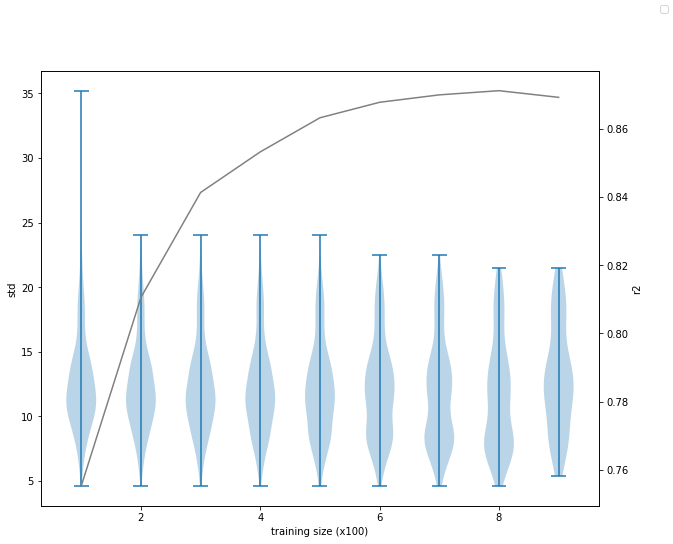

In [6]:
fig, ax1 = plt.subplots(figsize=(10,8))

ax1.violinplot([grouped.get_group(str(i*100))['std'] for i in range(1,10)])
ax1.set_xlabel('training size (x100)')
ax1.set_ylabel('std')

ax2 = ax1.twinx()
ax2.plot([i for i in range(1,10)], r2_out, c='gray')
ax2.set_ylabel('r2')
fig.legend()

In [11]:
grouped.get_group(str(300))['SMILES']

0         C/C=C(/C(C)(C)C)\C
1            C/C=C(/C(C)C)\C
2              C/C=C(/C=C)\C
3              C/C=C(\C=C)/C
4                    C/C=C/C
               ...          
764    Cc1ccc2c(c1)CCCC2(C)C
765      Cc1cccc(c1)C(C)(C)C
766         Cc1cccc(c1)C(C)C
767               Cc1ccccc1C
768           Cc1ccccc1C1CC1
Name: SMILES, Length: 769, dtype: object

In [20]:
kernel_list = [smile2graph(i) for i in grouped.get_group(str(300))['SMILES'].values]

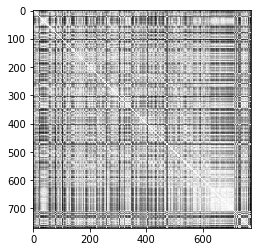

In [21]:
a_kernel = normal_kernel(kernel_list)
plt.imshow(a_kernel, cmap=plt.cm.gray)

(array([   69.,   361.,   977.,  2190.,  3935.,  6051.,  8344., 10919.,
        13077., 15108., 16129., 17749., 19841., 23291., 27482., 32272.,
        35923., 33393., 22159.,  6026.]),
 array([0.1995679 , 0.23958951, 0.27961114, 0.31963274, 0.35965437,
        0.399676  , 0.4396976 , 0.47971922, 0.5197408 , 0.5597625 ,
        0.5997841 , 0.6398057 , 0.67982733, 0.71984893, 0.7598705 ,
        0.7998921 , 0.8399138 , 0.8799354 , 0.919957  , 0.95997864,
        1.0000002 ], dtype=float32),
 <a list of 20 Patch objects>)

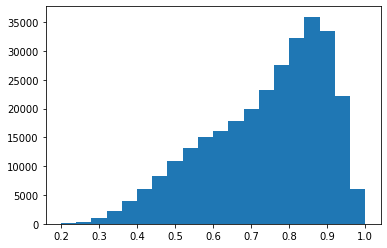

In [22]:
plt.hist(a_kernel[np.triu_indices(769, k = 1)], bins=20)

In [23]:
a_kernel

array([[1.        , 0.85063505, 0.77761316, ..., 0.5265604 , 0.4043081 ,
        0.39863202],
       [0.85063505, 1.0000001 , 0.8693567 , ..., 0.624412  , 0.41390145,
        0.48210093],
       [0.7776132 , 0.8693567 , 1.0000001 , ..., 0.63621545, 0.4934143 ,
        0.593604  ],
       ...,
       [0.5265604 , 0.624412  , 0.63621545, ..., 0.99999994, 0.92112744,
        0.91134816],
       [0.40430808, 0.41390142, 0.49341428, ..., 0.9211275 , 1.0000001 ,
        0.9251843 ],
       [0.39863205, 0.48210093, 0.593604  , ..., 0.9113482 , 0.9251843 ,
        0.99999994]], dtype=float32)

In [24]:
a_kernel[np.triu_indices(769, k = 1)]

array([0.85063505, 0.77761316, 0.77761316, ..., 0.92112744, 0.91134816,
       0.9251843 ], dtype=float32)

# T-P relationship

In [2]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
df = pd.read_csv('../data/result-ML-All-cp.txt', sep=' ')

In [3]:
datapoints = df[df['SMILES']==df.sample(n=1)['SMILES'].values[0]]

<IPython.core.display.Javascript object>


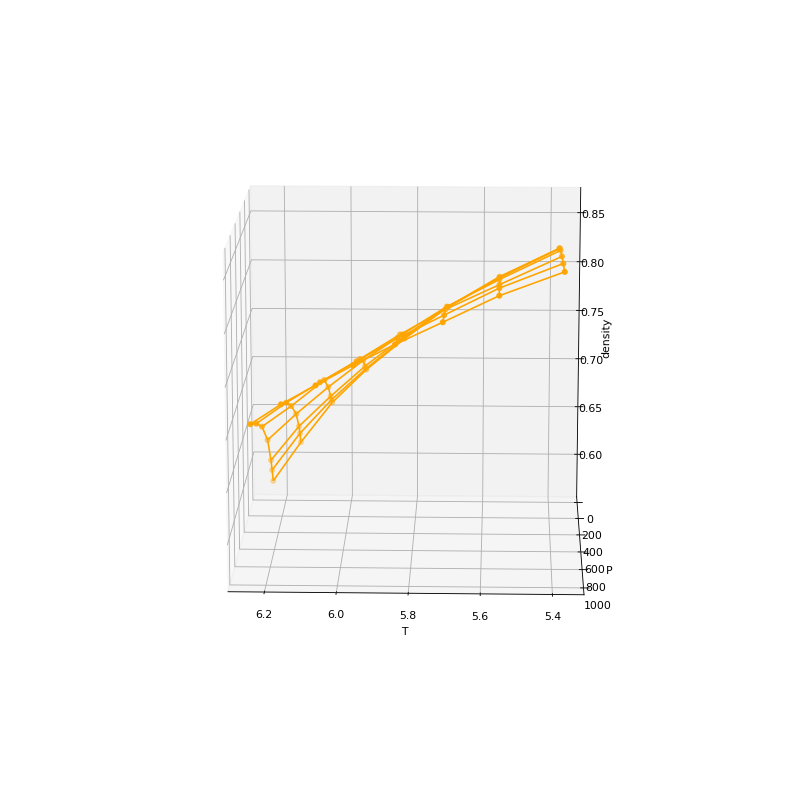

Text(0.5, 0, 'density')

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = np.log(datapoints['T'].values.reshape(7,-1))
y = datapoints['P'].values.reshape(7,-1)
z = datapoints['density'].values.reshape(7,-1)
ax.scatter3D(x, y, z, c='orange')
ax.plot_wireframe(X=x, Y=y, Z=z, linestyles='-', color='orange')
ax.view_init(elev=10., azim=200)
ax.set_xlabel('T')
ax.set_ylabel('P')
ax.set_zlabel('density')

<IPython.core.display.Javascript object>


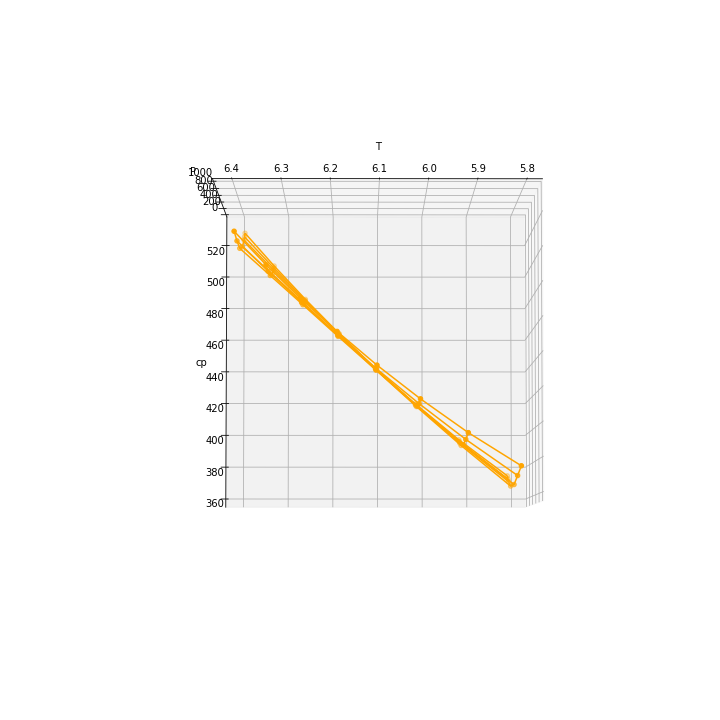

Text(0.5, 0, 'cp')

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x = np.log(datapoints['T'].values.reshape(7,-1))
y = datapoints['P'].values.reshape(7,-1)
z = datapoints['cp'].values.reshape(7,-1)
ax.scatter3D(x, y, z, c='orange')
ax.plot_wireframe(X=x, Y=y, Z=z, linestyles='-', color='orange')
ax.view_init(elev=10., azim=200)
ax.set_xlabel('T')
ax.set_ylabel('P')
ax.set_zlabel('cp')

# vis relationship

In [3]:
import matplotlib.pyplot as plt
df = pd.read_csv('../data/vis.txt', sep=' ')

In [52]:
df_sub = df.sample(n=100000)

In [60]:
df_sub.to_csv('../data/vis_subset.txt', sep=' ', index=False)

In [53]:
df_sub['vis_log'] = np.log(df_sub['vis'])

In [45]:
df[df.vis > 100]

,SMILES,T,vis,vis_u
3572,OC[C@H]([C@H]([C@@H]([C@@H]([C@H](CO)O)O)O)O)O,270.000,2.042160e+02,5.737510e+03
3573,OC[C@H]([C@H]([C@@H]([C@@H]([C@H](CO)O)O)O)O)O,276.375,1.244000e+02,3.005180e+03
217841,OC[C@H]([C@H]1OC(=O)C(=C1O)O)O,270.000,1.031940e+02,3.228840e+03
500648,CC(=O)OC(COC(=O)C)COC(=O)C,206.010,2.638360e+08,3.202730e+08
500649,CC(=O)OC(COC(=O)C)COC(=O)C,209.946,1.764090e+07,1.811130e+07
500650,CC(=O)OC(COC(=O)C)COC(=O)C,216.120,4.524120e+05,3.554620e+05
500651,CC(=O)OC(COC(=O)C)COC(=O)C,222.295,2.117890e+04,1.267040e+04
500652,CC(=O)OC(COC(=O)C)COC(=O)C,228.470,1.633420e+03,7.415160e+02
500653,CC(=O)OC(COC(=O)C)COC(=O)C,234.645,1.908230e+02,6.572270e+01
697863,N#Cc1c(O)ccc(c1C#N)O,270.000,1.117920e+02,3.072140e+03


In [56]:
datapoints = df[df['SMILES']==df.sample(n=1)['SMILES'].values[0]]
#datapoints = df[df['SMILES']=='OC[C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O']
#datapoints = df[df['SMILES']=='CC(=O)OC(COC(=O)C)COC(=O)C']
#datapoints = df[df['SMILES']=='OC[C@H]([C@H]([C@@H]([C@@H]([C@H](CO)O)O)O)O)O']

<IPython.core.display.Javascript object>


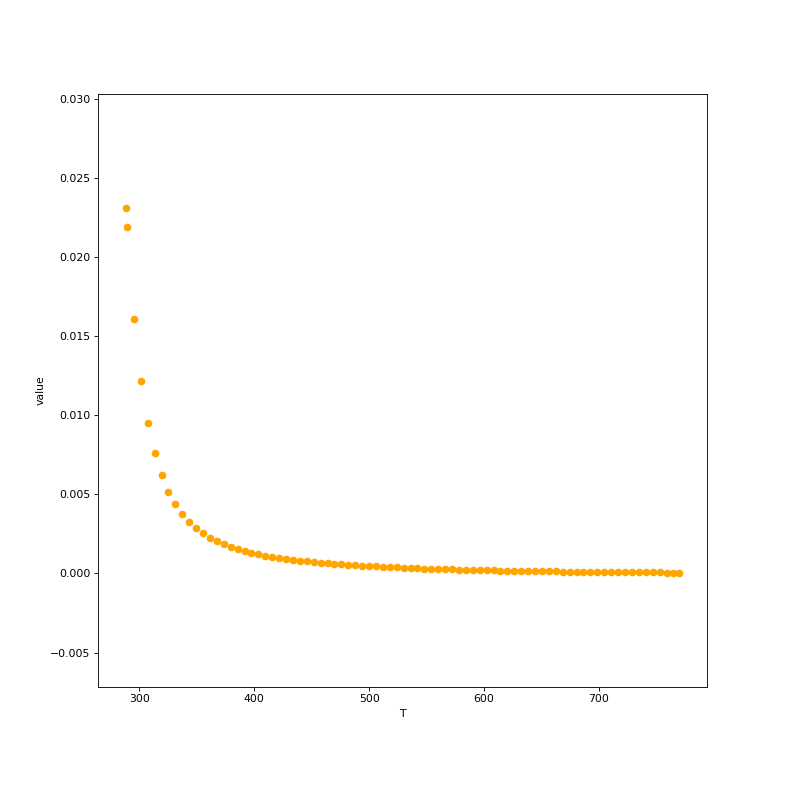

Text(0, 0.5, 'value')

In [57]:
fig = plt.figure(figsize=(10,10))
x = datapoints['T'].values
y = datapoints['vis'].values
plt.scatter(x, y, c='orange')
plt.xlabel('T')
plt.ylabel('value')

<IPython.core.display.Javascript object>


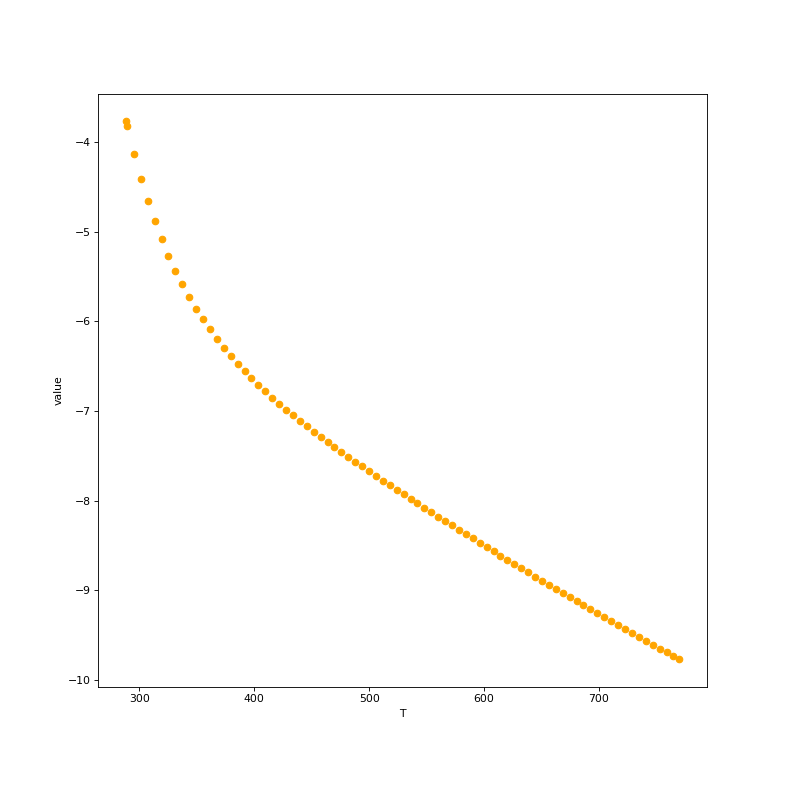

Text(0, 0.5, 'value')

In [58]:
fig = plt.figure(figsize=(10,10))
x = datapoints['T'].values
y = np.log(datapoints['vis'].values)
plt.scatter(x, y, c='orange')
plt.xlabel('T')
plt.ylabel('value')

# npt density AL result

In [16]:
class NewOutputHandler():
    def __init__(self, filename, relative_dir='../'):
        self.df = pd.read_csv(os.path.join(relative_dir, filename), sep=" ")
        self._parse_argument(filename)
    def _parse_argument(self, filename):
        #filename = re.split('/', filename)[1]
        self.target, self.learning_mode, self.add_mode, self.add_size = re.split('-', filename)

In [11]:
pathDir = os.listdir('../result-density-active')

In [12]:
pathDir

['density-supervised-nlargest-100.out',
 'density-supervised-nlargest-25.out',
 'density-unsupervised-nlargest-100.out',
 'density-random-cluster-25.out',
 'density-unsupervised-random-100.out',
 'density-random-nlargest-100.out',
 'density-unsupervised-nlargest-25.out',
 'density-unsupervised-random-25.out',
 'density-unsupervised-cluster-25.out',
 'density-unsupervised-cluster-100.out']

In [19]:
out_list_density = ['density-supervised-nlargest-100.out',
 'density-unsupervised-nlargest-100.out',
 'density-unsupervised-random-25.out',
 'density-random-nlargest-100.out',
 'density-unsupervised-cluster-100.out']

oh_list_density = [NewOutputHandler(i, '../result-density-active') for i in out_list_density]

<IPython.core.display.Javascript object>


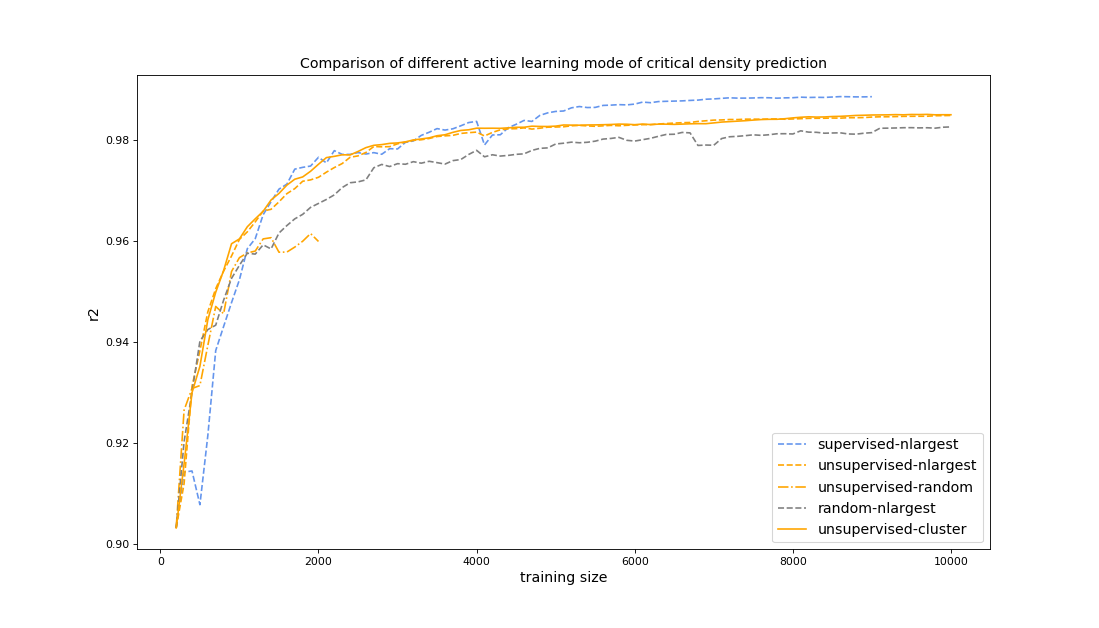

In [20]:
fig = plt.figure(figsize=(14,8))
for oh in oh_list_density:
    plot_oh(oh, get_str, 'r2')
fontsize = 13
#plt.plot(df_old_cluster['size'], df_old_cluster['r2'], c='r', label='old-unsupervised-cluster')

plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('r2', fontsize=fontsize)
plt.title('Comparison of different active learning mode of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [22]:
df = pd.read_csv('../density-unsupervised-10000.log',sep='\s+')

In [23]:
df.head()

,#sim,predict,uncertainty,abs_dev,rel_dev,T,P,smiles
0,0.6637,0.78609,0.28233,0.12239,0.18441,404,50,C1CCCCC1
1,0.6717,0.77319,0.12450,0.10149,0.15109,518,1,CC1C=CC=CC=C1
2,0.7014,0.80624,0.28149,0.10484,0.14947,404,250,C1CCCCC1
3,0.7180,0.81366,0.28133,0.09566,0.13324,364,100,C1CCCCC1
4,0.8071,0.90897,0.20477,0.10187,0.12622,395,100,CC1=CC=CC(C=C1)(C)C


In [63]:
def plot_prediction_line(df, size=None, error=True):
    y_mean = df['#sim'].mean()
    if size != None:
        df = df.sample(n=size)
    plt.figure(figsize=(8, 8))
    if error:
        plt.errorbar(df['#sim'], df['predict'], yerr=df['uncertainty']*y_mean, fmt= '.', alpha=0.2 )
    plt.scatter(df['#sim'], df['predict'], s=1)
    plt.plot( (min(df['#sim']), max(df['#sim'])), (min(df['#sim']), max(df['#sim'])), c='grey' )
    plt.plot( (min(df['#sim']), max(df['#sim'])), (min(df['#sim']) * 0.95, max(df['#sim']) * 0.95), c='gold', label='5%error line' )
    plt.plot( (min(df['#sim']), max(df['#sim'])), (min(df['#sim']) * 1.05, max(df['#sim']) * 1.05), c='gold')

    plt.xlabel('simu')
    plt.ylabel('pred')
    plt.legend()

In [64]:
df['#sim'].mean()

0.808433458189917

<IPython.core.display.Javascript object>


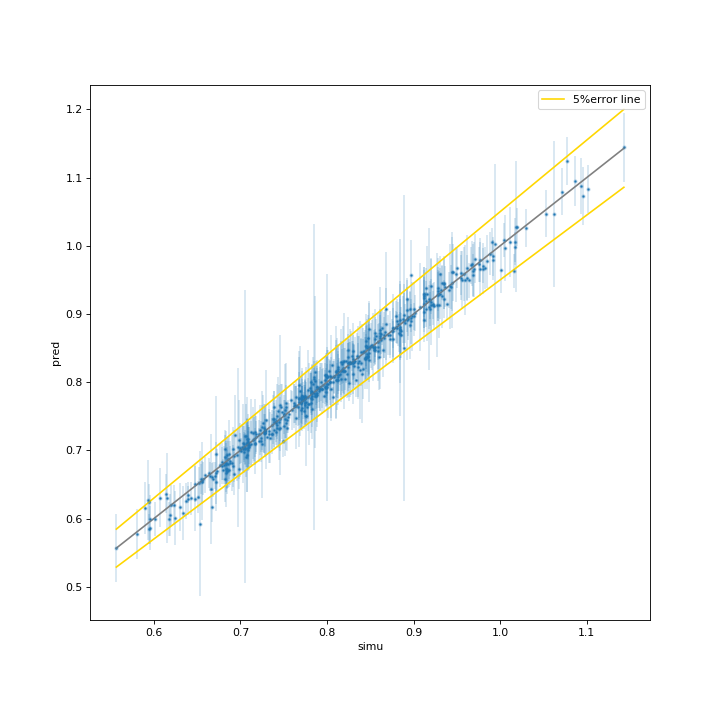

In [66]:
plot_prediction_line(df, size=500)

In [38]:
df['rel_err'] = abs(df['#sim'] - df['predict']) / df['#sim']

In [44]:
sum(df.rel_err < 0.05) / len(df)

0.989167847742458

# vis result

In [2]:
class NewOutputHandler():
    def __init__(self, filename, relative_dir='../'):
        self.df = pd.read_csv(os.path.join(relative_dir, filename), sep=" ")
        self._parse_argument(filename)
    def _parse_argument(self, filename):
        #filename = re.split('/', filename)[1]
        self.target, self.learning_mode, self.add_mode, self.add_size = re.split('-', filename)

In [4]:
os.listdir('../result-vis')

['vis_log-unsupervised-cluster-100-old.out',
 'vis_log-supervised-nlargest-100.out',
 'vis_log-random-nlargest-100.out',
 'vis_log-unsupervised-cluster-100.out',
 'vis_log-unsupervised-nlargest-100-old.out',
 'vis_log-unsupervised-nlargest-100.out']

In [11]:
out_list_density = [
 'vis_log-supervised-nlargest-100.out',
 'vis_log-random-nlargest-100.out',
 'vis_log-unsupervised-cluster-100.out',
 'vis_log-unsupervised-nlargest-100.out']

oh_list_density = [NewOutputHandler(i, '../result-vis') for i in out_list_density]

fig = plt.figure(figsize=(14,8))
for oh in oh_list_density:
    plot_oh(oh, get_str, 'r2')
fontsize = 13
#plt.plot(df_old_cluster['size'], df_old_cluster['r2'], c='r', label='old-unsupervised-cluster')

plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('r2', fontsize=fontsize)
plt.title('Comparison of different active learning mode of vis', fontsize=fontsize)
plt.legend(fontsize=fontsize)

<IPython.core.display.Javascript object>

# uncertainty vs. error relationship

In [28]:
df = pd.read_csv('../result-density-test/3000.log',sep='\s+')
df_train = pd.read_csv('../result-density-test/3000-train.log',sep='\s+')

In [51]:
df.head(25)

,#sim,predict,uncertainty,abs_dev,rel_dev,T,P,smiles,rel_err
0,0.6637,0.78609,0.28233,0.12239,0.18441,404,50,C1CCCCC1,0.184406
1,0.6717,0.77319,0.12450,0.10149,0.15109,518,1,CC1C=CC=CC=C1,0.151094
2,0.7014,0.80624,0.28149,0.10484,0.14947,404,250,C1CCCCC1,0.149472
3,0.7180,0.81366,0.28133,0.09566,0.13324,364,100,C1CCCCC1,0.133231
4,0.8071,0.90897,0.20477,0.10187,0.12622,395,100,CC1=CC=CC(C=C1)(C)C,0.126217
5,0.7388,0.82478,0.28143,0.08598,0.11637,344,100,C1CCCCC1,0.116378
6,1.1910,1.05787,0.11773,0.13313,0.11178,471,750,c1ccc2c(c1)Oc1c(O2)cccc1,0.111780
7,1.1580,1.02922,0.11649,0.12878,0.11121,497,500,c1ccc2c(c1)Oc1c(O2)cccc1,0.111209
8,0.7109,0.78912,0.28054,0.07822,0.11003,429,1,c1ccccc1,0.110030
9,0.8399,0.92970,0.20728,0.08980,0.10691,395,500,CC1=CC=CC(C=C1)(C)C,0.106917


<IPython.core.display.Javascript object>


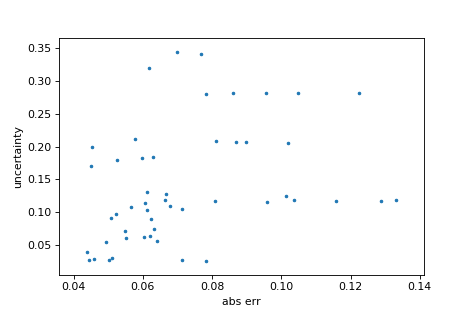

Text(0, 0.5, 'uncertainty')

In [52]:
plt.figure()
plt.scatter(df.head(50)['abs_dev'],df.head(50)['uncertainty'], s=5)
plt.xlabel('abs err')
plt.ylabel('uncertainty')

<IPython.core.display.Javascript object>


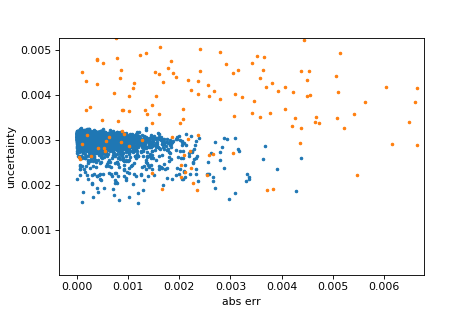

Text(0, 0.5, 'uncertainty')

In [16]:
plt.figure()
plt.scatter(df_train['abs_dev'],df_train['uncertainty'], s=5)
plt.xlabel('abs err')
plt.ylabel('uncertainty')